In [9]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy import fft, signal
from scipy.linalg import circulant
from scipy.sparse.linalg import LaplacianNd
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.neighbors import BallTree
from tqdm import tqdm
from copy import deepcopy

%matplotlib inline

In [10]:
SRC_IMG_PATH = 'DIPSourceHW2.png'
PATCH_SIZE = 15
ALPHA = 3
GAUSS_STD = 5.0

In [11]:
orig_image = cv2.imread(SRC_IMG_PATH, cv2.IMREAD_GRAYSCALE).astype(float) / 255.0
height, width = orig_image.shape
width_pad = 0 if width % ALPHA == 0 else ALPHA - width % ALPHA
height_pad = 0 if height % ALPHA == 0 else ALPHA - height % ALPHA
resized_height, resized_width = width + width_pad, height + height_pad

# pad image so both sides will be multiple of ALPHA (zero padding)
padded_image = np.pad(orig_image, ((0, height_pad), (0, width_pad)))

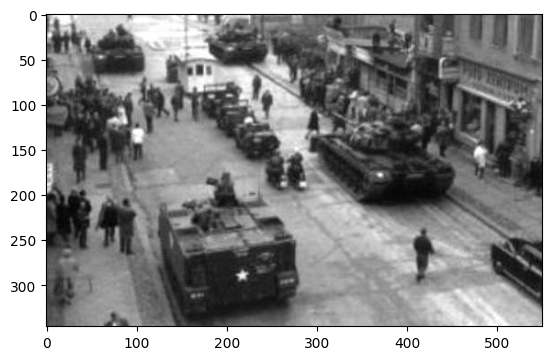

In [12]:
plt.imshow(orig_image, cmap='gray')
plt.show()

In [13]:
def create_gaussian_kernel(kernel_size, std=GAUSS_STD):
    kernel_radius = kernel_size // 2
    x = np.arange(-kernel_radius, kernel_radius + 1, dtype=float)
    kernel = np.exp(-(x**2 + x.reshape(-1, 1)**2) / (2 * std**2))
    return kernel / np.sum(kernel)

def create_sinc_kernel(kernel_size):
    kernel_radius = kernel_size // 2
    x = np.arange(-kernel_radius, kernel_radius + 1, dtype=float)
    kernel = np.sinc(np.outer(x, x))
    return kernel / np.sum(kernel)

def apply_psf(image, psf):
    return signal.convolve2d(image, psf, mode='same', boundary='wrap')

def downsample(image, alpha=ALPHA):
    return image[::alpha, ::alpha]

In [14]:
# Create low and high resolution images with sinc and gaussian kernels
sinc_kernel = create_sinc_kernel(PATCH_SIZE)
sinc_high_res = apply_psf(orig_image, sinc_kernel)
gaussian_kernel = create_gaussian_kernel(PATCH_SIZE)
gaussian_high_res = apply_psf(orig_image, gaussian_kernel)
sinc_low_res = downsample(sinc_high_res)
gaussian_low_res = downsample(gaussian_high_res)

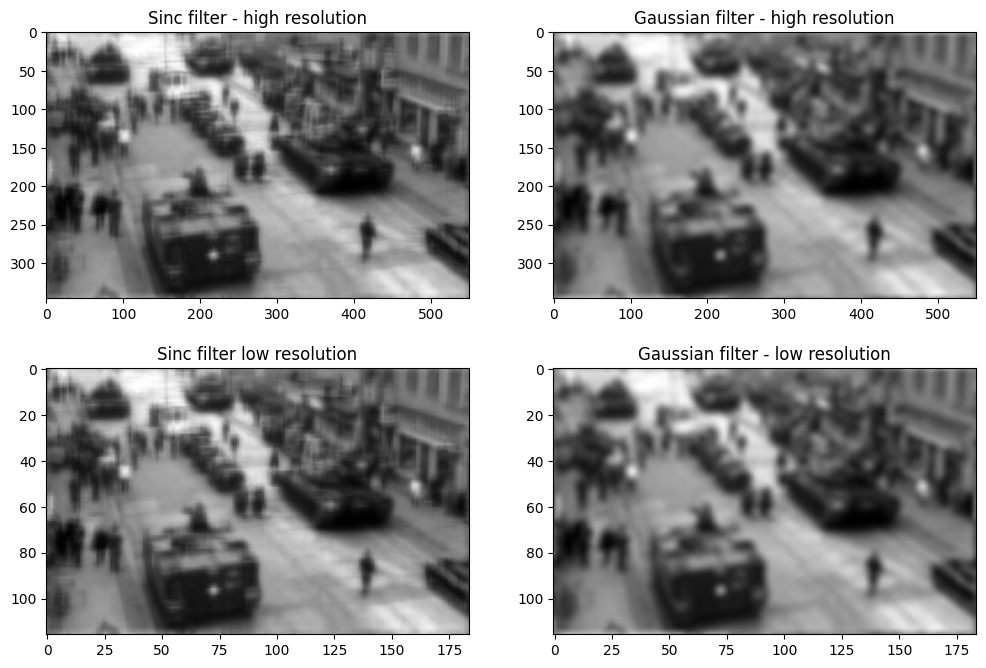

In [15]:
# Plot low and high resolution images
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs[0, 0].imshow(sinc_high_res, cmap='gray')
axs[0, 0].set_title('Sinc filter - high resolution')
axs[0, 1].imshow(gaussian_high_res, cmap='gray')
axs[0, 1].set_title('Gaussian filter - high resolution')
axs[1, 0].imshow(sinc_low_res, cmap='gray')
axs[1, 0].set_title('Sinc filter low resolution')
axs[1, 1].imshow(gaussian_low_res, cmap='gray')
axs[1, 1].set_title('Gaussian filter - low resolution')
plt.show()

In [16]:
plot_and_save_fig(sinc_low_res, title='Sinc filter - low resolution', filename='sinc_low_res.png')

NameError: name 'plot_and_save_fig' is not defined

In [ ]:
plot_and_save_fig(gaussian_low_res, title='Gaussian filter - low resolution', filename='gaussian_low_res.png')

In [ ]:
# Print PSNR for low and high resolution images (just for comparison)
print('Sinc PSNR:', psnr(sinc_high_res, orig_image))
print('Gaussian PSNR:', psnr(gaussian_high_res, orig_image))

In [ ]:
# Auxiliary functions
def get_patches(img, patch_size, step_size):
    """
    Returns an array of patches from the image.
    """
    return np.array([
        img[i:i+patch_size, j:j+patch_size].flatten()
            for i in range(0, img.shape[0] - patch_size, step_size)
                for j in range(0, img.shape[1] - patch_size, step_size)
    ])

def downsample_rows(mat, alpha):
    return mat[::alpha, :]

def reconstruct_image(low_res_img, kernel, k=0.1, alpha=ALPHA):
    """
    Reconstruct the original image from the low resolution image by upsampling and applying wiener filter with the
    given kernel (implementation based on the tutorial).
    """
    kernel = deepcopy(kernel)  # make sure to not change the original kernel.
    if np.sum(kernel) > 0:
        kernel /= np.sum(kernel)
    upsampled_img = cv2.resize(low_res_img,
                               dsize=(low_res_img.shape[1] * alpha, low_res_img.shape[0] * alpha),
                               interpolation=cv2.INTER_CUBIC)
    kernel = fft.fft2(kernel, s=upsampled_img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + k)
    return np.abs(fft.ifft2(fft.fft2(upsampled_img) * kernel))

def plot_and_save_fig(img, *, title, filename):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.savefig(filename)
    plt.show()

def reconstruct_plot_and_save(low_res_img, kernel, blurred_with, reconst_with):
    """
    Reconstruct the high resolution image from the low resolution image using the given kernel.
    Plot the reconstructed image and save it to a file with the PSNR value.
    """
    reconst = reconstruct_image(low_res_img, kernel)
    # Use only the original image size (without padding) for PSNR calculation.
    psnr_val = psnr(orig_image[:height, :width], reconst[:height, :width], data_range=1.0)
    title = f'Blurred with {blurred_with}, reconstructed with {reconst_with} - PSNR: {psnr_val:.2f}'
    filename = f'{blurred_with}-{"_".join(reconst_with.split())}.png'
    plot_and_save_fig(reconst, title=title, filename=filename)


In [ ]:
def estimate_kernel(low_res_img,
                    patch_size=PATCH_SIZE,
                    alpha=ALPHA,
                    num_iter=15,
                    sigma=1    # best sigma value found after experiments (for the specific image provided).
                    ):
    """
    Implementation of the algoithm from the paper:
    "Nonparametric Blind Super-Resolution" by Tomer Michaeli and Michal Irani

    :param low_res_img: The low resolution image.
    :param patch_size: Size of each patch from the high resolution image.
    :param alpha: Scale factor between the low resolution and high resolution images.
    :param num_iter: Number of iteration to run the algorithm for. The paper mentioned that the algorithm converged
        after ~iterations.
    :param sigma: The sigma value to use in the algorithm.
    :return: The estimated kernel of shape (patch_size, patch_size).
    """
    # Size of q patches is the size of the high resolution patch divided by alpha.
    q_patch_size = patch_size // alpha
    # Create high (r) and low (q) resolution patches from the low resolution image.
    r_patches = get_patches(low_res_img, patch_size, alpha)
    q_patches = get_patches(low_res_img, q_patch_size, alpha)

    # Create Rj matrices. Each matrix corresponding to convolution with patch r[j] and sub-sampling by alpha.
    Rj = np.array([downsample_rows(circulant(r_patch), alpha ** 2) for r_patch in r_patches])

    # initialize k_hat with delta function.
    k_hat = signal.unit_impulse(patch_size ** 2, idx='mid')

    # Create C matrix for the regularization term.
    C = LaplacianNd((patch_size, patch_size)).toarray()
    CT_C = C.T @ C

    for _ in (range(num_iter)):
        # Calculate r_alpha patches as Rj @ k_hat.flatten().
        r_alpha_patches = [M @ k_hat for M in Rj]

        # Calculate neighbors weights
        with np.errstate(divide='ignore', invalid='ignore'):
            tree = BallTree(r_alpha_patches, leaf_size=2)
            weights = np.zeros((len(q_patches), len(r_alpha_patches)), dtype=float)
            for i, q_patch in enumerate(q_patches):
                _, neig_idxs = tree.query(q_patch[np.newaxis], k=10)
                for j in neig_idxs.squeeze():
                    weights[i, j] = \
                        np.exp(-(np.linalg.norm(q_patch - r_alpha_patches[j]) ** 2) / (2 * sigma ** 2))
            # normalize weights. If there are rows with sum 0, the values in these rows will become NaN.
            weights /= np.sum(weights, axis=1).reshape(-1, 1)

        # Get indices of non-zero weights (as tuple of row indices and column indices arrays).
        row_indices, col_indices = np.where(weights > 0.0)

        # Calculate left and right sum terms in the formula.
        left_term = np.zeros((k_hat.shape[0], k_hat.shape[0]))
        right_term = np.zeros_like(k_hat)

        # pre-calculate Rj.T @ Rj only for col_indices.
        # (don't want to calculate in each iteration because there are many duplicates).
        RjT_Rj_vec = np.empty((len(Rj), k_hat.shape[0], k_hat.shape[0]))
        for j in col_indices:
            RjT_Rj_vec[j] = Rj[j].T @ Rj[j]

        for i, j in zip(row_indices, col_indices):
            left_term += weights[i, j] * RjT_Rj_vec[j]
            right_term += weights[i, j] * Rj[j].T @ q_patches[i]

        k_hat = np.linalg.inv(left_term / (sigma ** 2) + CT_C) @ right_term

    return k_hat.reshape((patch_size, patch_size))

In [ ]:
sinc_estimated_kernel = estimate_kernel(sinc_low_res)
gaussian_estimated_kernel = estimate_kernel(gaussian_low_res)

In [ ]:
reconstruct_plot_and_save(sinc_low_res, sinc_estimated_kernel, "sinc", "estimated sinc")

In [ ]:
reconstruct_plot_and_save(sinc_low_res, gaussian_estimated_kernel, "sinc", "estimated gaussian")

In [ ]:
reconstruct_plot_and_save(sinc_low_res, sinc_kernel, "sinc", "original sinc")

In [ ]:
reconstruct_plot_and_save(gaussian_low_res, gaussian_estimated_kernel, "gaussian", "estimated gaussian")

In [ ]:
reconstruct_plot_and_save(gaussian_low_res, sinc_estimated_kernel, "gaussian", "estimated sinc")

In [ ]:
reconstruct_plot_and_save(gaussian_low_res, gaussian_kernel, "gaussian", "original gaussian")